In [25]:
%%capture
!pip install langgraph langchain-openai langchain python-dotenv haversine

In [ ]:
# Define the URL
url = 'https://places.googleapis.com/v1/places:searchText'

# Define the headers
headers = {
    'Content-Type': 'application/json',
    'X-Goog-Api-Key': os.environ['GOOGLE_MAPS_API_KEY'],
    'X-Goog-FieldMask': 'places.name,places.types,places.nationalPhoneNumber,places.formattedAddress,places.location,places.rating,places.googleMapsUri,places.websiteUri,places.regularOpeningHours,places.priceLevel,places.userRatingCount,places.displayName,places.primaryTypeDisplayName,places.reviews,places.dineIn,places.servesLunch,places.servesDinner,places.outdoorSeating,places.liveMusic,places.servesDessert,places.servesBeer,places.servesWine,places.servesBrunch,places.servesCocktails,places.servesCoffee,places.servesVegetarianFood,places.goodForChildren,places.menuForChildren,places.goodForGroups,places.parkingOptions'
}

# Define the data payload
data = {
    'textQuery': 'Spicy Vegetarian Food in Sydney, Australia'
}

# Make the POST request
response = requests.post(url, headers=headers, json=data)

In [12]:
# stream response to a text file
with open('response.txt', 'wb') as f:
    f.write(response.content)

In [8]:
%load_ext autoreload
%autoreload 2

In [7]:
# convert response to json
json_response = response.json()

In [8]:
places = json_response['places']

In [ ]:
places

In [10]:
# instantiate a place from response content
place = Place.model_validate(places[0])

In [17]:
places_objects

[Place(name='places/ChIJwWB_qT2uEmsRbE92vXMyX4Q', types=['vegan_restaurant', 'vegetarian_restaurant', 'chinese_restaurant', 'restaurant', 'food', 'point_of_interest', 'establishment'], national_phone_number='(02) 9283 2828', formatted_address='367 Pitt St, Sydney NSW 2000, Australia', location=Coordinates(latitude=-33.875924999999995, longitude=151.20777099999998), rating=4.4, google_maps_uri='https://maps.google.com/?cid=9538398008475275116', website_uri='http://www.motherchusvegetarian.com.au/', regular_opening_hours=RegularOpeningHours(periods=[OpenClosePeriod(open=TimeInfo(day=1, hour=12, minute=0), close=TimeInfo(day=1, hour=15, minute=0)), OpenClosePeriod(open=TimeInfo(day=1, hour=17, minute=0), close=TimeInfo(day=1, hour=21, minute=0)), OpenClosePeriod(open=TimeInfo(day=2, hour=12, minute=0), close=TimeInfo(day=2, hour=15, minute=0)), OpenClosePeriod(open=TimeInfo(day=2, hour=17, minute=0), close=TimeInfo(day=2, hour=21, minute=0)), OpenClosePeriod(open=TimeInfo(day=3, hour=12, 

In [22]:
places_objects = []
for p in places:
    places_objects.append(Place.model_validate(p))

In [4]:
TEST_COORDS = (30.320156, -97.720618)
TEST_LAT = TEST_COORDS[0]
TEST_LONG = TEST_COORDS[1]

In [11]:
# Define the URL
url = 'https://places.googleapis.com/v1/places:searchText'

# Define the headers
headers = {
    'Content-Type': 'application/json',
    'X-Goog-Api-Key': os.environ['GOOGLE_MAPS_API_KEY'],
    'X-Goog-FieldMask': 'places.name,places.types,places.nationalPhoneNumber,places.formattedAddress,places.location,places.rating,places.googleMapsUri,places.websiteUri,places.regularOpeningHours,places.priceLevel,places.userRatingCount,places.displayName,places.primaryTypeDisplayName,places.reviews,places.dineIn,places.servesLunch,places.servesDinner,places.outdoorSeating,places.liveMusic,places.servesDessert,places.servesBeer,places.servesWine,places.servesBrunch,places.servesCocktails,places.servesCoffee,places.servesVegetarianFood,places.goodForChildren,places.menuForChildren,places.goodForGroups,places.parkingOptions'
}

# Define the data payload
data = {
    'textQuery': 'Asian cuisine near me',
    'locationBias': {
        'circle': {
            'center': {
                'latitude': TEST_LAT,
                'longitude': TEST_LONG
            },
            'radius': 8046.72
        }
    }
}

# Make the POST request
response = requests.post(url, headers=headers, json=data)

## Making our food finder graph

### Version 1:

user → map query formulator agent → team supervisor w/ tool call → final output on UI completed

In [42]:
import os
import requests
from typing import Annotated, Sequence, Tuple, List, Dict, Any
from datetime import datetime, timedelta, time
import operator
import math
from pydantic import BaseModel, Field
from colorama import Fore, Style

from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.tools import tool
from langgraph.prebuilt import InjectedState, ToolNode

from langgraph.graph import END, StateGraph

from app.schemas import Place, UserPreferences

In [82]:
# Custom class for AIMessage, which also includes the graph node which produced it
class CustomAIMessage(AIMessage):
    def __init__(self, content: str, originating_node: str, **kwargs):
        super().__init__(content=content, **kwargs)
        self.originating_node = originating_node

In [83]:
# reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
from dotenv import load_dotenv
load_dotenv('../../.env.dev')
GOOGLE_FIELD_MASK = "places.name,places.types,places.nationalPhoneNumber,places.formattedAddress,places.location,places.rating,places.googleMapsUri,places.websiteUri,places.regularOpeningHours,places.priceLevel,places.userRatingCount,places.displayName,places.primaryTypeDisplayName,places.reviews,places.dineIn,places.servesLunch,places.servesDinner,places.outdoorSeating,places.liveMusic,places.servesDessert,places.servesBeer,places.servesWine,places.servesBrunch,places.servesCocktails,places.servesCoffee,places.servesVegetarianFood,places.goodForChildren,places.menuForChildren,places.goodForGroups,places.parkingOptions"

### Define our prompts

In [85]:
from app.graph.prompts import MAPS_QUERY_FORMULATOR_SYSTEM_PROMPT, TEAM_SUPERVISOR_SYSTEM_PROMPT

### Define our state and LLM

In [86]:
from app.schemas import AgentState

In [87]:
llm = ChatOpenAI(model="gpt-4o")

### Create maps query formulator agent

This agent takes all the info we have no the user's request and formulates a query for the Google Maps API.

In [88]:
def maps_query_formulator_node(state: AgentState):
    # add the system prompt before
    messages = [SystemMessage(content=MAPS_QUERY_FORMULATOR_SYSTEM_PROMPT)] + state["messages"]
    response = llm.invoke(messages)

    new_message = CustomAIMessage(content=response.content, originating_node="maps_query_formulator_node")
    return {"messages": [new_message]}

### Create state updater agent

This agent will take the information from the user query (initial one for now) and update the state with the user's preferences.

Here is an example of getting structured output from a LLM

In [89]:
class DateTimeExtract(BaseModel):
    dt: datetime

model = ChatOpenAI(model="gpt-4o", temperature=0)

DATETIME_EXTRACTOR_SYSTEM_PROMPT = """
{curr_day_time_msg}. Give back a datetime object, in the `dt` key of the JSON, from the following user query:
{user_query}
"""

def get_formatted_datetime():
    now = datetime.now()
    return now.strftime("It is currently %B %d, %Y. The time is %I:%M %p")

def extract_datetime(message: str) -> DateTimeExtract:
    structured_llm = model.with_structured_output(DateTimeExtract, method="json_mode")
    message = DATETIME_EXTRACTOR_SYSTEM_PROMPT.format(curr_day_time_msg=get_formatted_datetime(), user_query=message)
    return structured_llm.invoke(message)

In [139]:
def datetime_extractor_node(state: AgentState):
    # Grab the first human message's content
    user_query = next((msg.content for msg in state["messages"] if isinstance(msg, HumanMessage)), None)
    structured_model = llm.with_structured_output(DateTimeExtract)
    message = DATETIME_EXTRACTOR_SYSTEM_PROMPT.format(curr_day_time_msg=get_formatted_datetime(), user_query=user_query)

    response = structured_model.invoke(message)

    # Now, return the updated desired time to eat
    new_user_pref = state['user_preferences']
    orig_stay_duration = new_user_pref.desired_time_and_stay_duration[1]
    new_user_pref.desired_time_and_stay_duration = (response.dt, orig_stay_duration)
    return {"user_preferences": new_user_pref, "datetime_extracted": True}

In [91]:
query_tests = [
    "Im looking for a place to have dinner around 7 PM, preferably somewhere within 10 miles of downtown. I’d love a spot with a cozy atmosphere and a good selection of vegetarian dishes, but I’m open to other options if they have unique or standout menu items. Bonus points if they have outdoor seating and a view!",
    "I’m looking for a place to eat that serves Italian food. I’d prefer it to be within 5 miles of my current location, and I’d like it to be open for dinner. I’d prefer it to be a place that has a good atmosphere and serves good food. I’d also like it to have a good selection of vegetarian dishes, but I’m open to other options if they have unique or standout menu items. Bonus points if they have outdoor seating and a view!",
    "Tomorrow, I want to get some asian food by my house, during dinner.",
    "This Friday, im going out to eat at lunch time. What is good?",
    "I want to get some italian food during Halloween this year."
]

In [92]:
for q in query_tests:
    print(extract_datetime(q).dt)

2024-09-25 19:00:00
2024-09-25 15:28:00
2024-09-26 19:00:00
2024-09-27 12:00:00
2024-10-31 00:00:00


In [93]:
from app.schemas import PreferenceWeight

In [127]:
class StateUpdaterOutputFormat(BaseModel):
    when_to_eat_specified: bool = Field(default=False)
    length_of_stay: int = Field(default=60)
    preferred_price_level: str = Field(default="PRICE_LEVEL_UNSPECIFIED")
    desired_star_rating: int = Field(default=0)
    preferred_direction: str = Field(default="any")
    desired_max_distance_meters: float = Field(default=16093.0)

    desired_cuisines: PreferenceWeight = Field(default=PreferenceWeight(value=["any"], weight=0.8))
    party_size: PreferenceWeight = Field(default=PreferenceWeight(value=1, weight=1.0))
    desired_minimum_num_ratings: PreferenceWeight = Field(default=PreferenceWeight(value=0, weight=0.3))
    dietary_requests: PreferenceWeight = Field(default=PreferenceWeight(value=[], weight=1.0))
    wants_family_friendly: PreferenceWeight = Field(default=PreferenceWeight(value=False, weight=0.6))
    wants_childrens_menu: PreferenceWeight = Field(default=PreferenceWeight(value=False, weight=0.5))
    wants_free_parking: PreferenceWeight = Field(default=PreferenceWeight(value=True, weight=0.8))
    wants_outdoor_seating: PreferenceWeight = Field(default=PreferenceWeight(value=False, weight=0.5))
    wants_live_music: PreferenceWeight = Field(default=PreferenceWeight(value=False, weight=0.3))
    wants_dessert: PreferenceWeight = Field(default=PreferenceWeight(value=False, weight=0.3))
    wants_beer: PreferenceWeight = Field(default=PreferenceWeight(value=False, weight=0.3))
    wants_wine: PreferenceWeight = Field(default=PreferenceWeight(value=False, weight=0.3))
    wants_brunch: PreferenceWeight = Field(default=PreferenceWeight(value=False, weight=0.7))
    wants_cocktails: PreferenceWeight = Field(default=PreferenceWeight(value=False, weight=0.3))
    wants_coffee: PreferenceWeight = Field(default=PreferenceWeight(value=False, weight=0.6))


In [128]:
STATE_UPDATER_SYSTEM_PROMPT = """
You are an AI assistant tasked with extracting user preferences for dining from their message, responding back in JSON.

Each preference (key in the JSON) has an associated value and weight. The value is what you will extract from the message (if 
the user provided it), and the weight (a value from 0.0 to 1.0) of an extracted value can be determined by gauging how 
important this preference is to the user. You can use the following heuristic to determine weight values, based on what you see
in the user's message:
- Need -> 1.0
- Strongly want -> 0.8
- Want -> 0.5
- Nice to have -> 0.3

Here are the keys of the JSON, or user preferences to look for, and how youll need to format the information to extract the value for each. 
Fill out each one, if you see it in the message, otherwise, you can use the default values.
- `when_to_eat_specified`: Format this as a boolean, representing whether the user has specified when they would like to eat.
    - example value: true
- `length_of_stay`: Format this as an integer, representing the number of minutes the user would like to stay at the place.
    - example value: 30
- `preferred_price_level`: Format this as a string. The user will likely give you a price or price range (assume USD). If they dont give you this but indicate a preference for cost another way, do your best to give the more appropriate price level. Here are the mappings of price ranges (per person) to the corresponding values to give back:
    - <= $10 -> "PRICE_LEVEL_INEXPENSIVE"
    - $10 - $30 -> "PRICE_LEVEL_MODERATE"
    - $30 - $60 -> "PRICE_LEVEL_EXPENSIVE"
    - >$60 -> "PRICE_LEVEL_VERY_EXPENSIVE"
- `desired_star_rating`: Format this as a float, representing any preference the user may have for the average rating of a place (at minimum). Ranges from 0.0 to 5.0.
    - example value: 4.6
- `preferred_direction`: Format this as a string, representing the user's preferred direction on a compass for where the place is located. Only fill this in if the direction is in relation to where they are.
    - example value: "NE"
- `desired_max_distance_meters`: Format this as a float, representing any preference the user may have for the maximum distance they would like to travel to eat. This is measured in meters, but it is likely they will give you number for miles, hence, convert first. If the user specifies a desired travel time instead, dont fill out this value.
    - example value: 16093.0
- `desired_cuisines`: Format this into a list of strings, based on the user's preferred kind(s) of food to eat.
    - example value: ["American"]
- `party_size`: Format this as an integer representing how many people are in the user's party. If not explicitly specified, assume 1.
    - example value: 2
- `desired_minimum_num_ratings`: Format this as a float, representing any preference the user may have for the number of ratings they desire from a place (at minimum). Ranges from 0.0 to 5.0.
    - example value: 4.6
- `dietary_requests`: Format this into a list of strings, based on the user's dietary requests. Make this be [""] if no requests are given.
    - example value: ["Vegetarian", "Gluten-free"]
- `wants_family_friendly`: Format this as a boolean, representing the user's preference for a family-friendly environment.
    - example value: true
- `wants_childrens_menu`: Format this as a boolean, representing the user's preference for a children's menu.
    - example value: true
- `wants_free_parking`: Format this as a boolean, representing the user's preference for free parking. If not specified, assume true.
    - example value: true
- `wants_outdoor_seating`: Format this as a boolean, representing the user's preference for outdoor seating.
    - example value: true
- `wants_live_music`: Format this as a boolean, representing the user's preference for live music.
    - example value: true
- `wants_dessert`: Format this as a boolean, representing the user's preference for dessert.
    - example value: true
- `wants_beer`: Format this as a boolean, representing the user's preference for beer.
    - example value: true
- `wants_wine`: Format this as a boolean, representing the user's preference for wine.
    - example value: true
- `wants_brunch`: Format this as a boolean, representing the user's preference for brunch.
    - example value: true
- `wants_cocktails`: Format this as a boolean, representing the user's preference for cocktails.
    - example value: true
- `wants_coffee`: Format this as a boolean, representing the user's preference for coffee.
    - example value: true

An example output, thus, would be:
{
    ...
    "desired_minimum_num_ratings": {
        "value": 100,
        "weight": 0.3
    },
    ...
    "wants_childrens_menu": {
        "value": true,
        "weight": 0.7
    },
    ...
}
"""

In [115]:
model = ChatOpenAI(model="gpt-4o", temperature=0)

def extract_preferences(message: str) -> Dict[str, Any]:
    structured_model = model.with_structured_output(StateUpdaterOutputFormat)
    
    response = structured_model.invoke([
        SystemMessage(content=STATE_UPDATER_SYSTEM_PROMPT),
        HumanMessage(content=message)
    ])
    
    return response.dict()


In [164]:
def state_updater_node(state: AgentState):
    # Grab the first human message's content
    user_query_with_preferences = next((msg.content for msg in state["messages"] if isinstance(msg, HumanMessage)), None)
    structured_model = llm.with_structured_output(StateUpdaterOutputFormat)

    response = structured_model.invoke([
        SystemMessage(content=STATE_UPDATER_SYSTEM_PROMPT),
        HumanMessage(content=user_query_with_preferences)
    ])
    new_preferences = response.dict()

    # After we get response preferences, we update the state
    # Note: We dont need to append an additional message from this agent to the state
    # Just need to update the other aspects of the state
    state_to_return = {}
    
    pref_restrictions = {k: new_preferences[k] for k in list(new_preferences.keys())[:6]}
    for k, v in pref_restrictions.items():
        if k == "length_of_stay":
            new_user_pref = state["user_preferences"]
            orig_user_pref_time_of_stay = state["user_preferences"].desired_time_and_stay_duration[0]
            new_user_pref.desired_time_and_stay_duration = (orig_user_pref_time_of_stay, v)
            state_to_return["user_preferences"] = new_user_pref
        else:
            state_to_return[k] = v

    pref_rest = {k: new_preferences[k] for k in list(new_preferences.keys())[6:]}
    user_preferences = UserPreferences.model_validate(pref_rest)
    state_to_return["user_preferences"] = user_preferences

    # Handling any other state variables not included in the StateUpdaterOutputFormat schema
    state_to_return["when_to_eat_specified"] = state["when_to_eat_specified"]

    return state_to_return

In [122]:
d = extract_preferences("Im looking for a place to have dinner around 7 PM, preferably somewhere within 10 miles of downtown. I'd love a spot with a cozy atmosphere and a good selection of vegetarian dishes, but I'm open to other options if they have unique or standout menu items. Bonus points if they have outdoor seating and a view!")

In [100]:
d = extract_preferences(query_tests[0])

In [101]:
print(query_tests[0])

Im looking for a place to have dinner around 7 PM, preferably somewhere within 10 miles of downtown. I’d love a spot with a cozy atmosphere and a good selection of vegetarian dishes, but I’m open to other options if they have unique or standout menu items. Bonus points if they have outdoor seating and a view!


### Create team supervisor agent

#### Create tool nodes for supervisor, which have access to state

In [102]:
from app.graph.tools.places_search import google_maps_text_search_and_filter

In [103]:
tool_node = ToolNode([google_maps_text_search_and_filter])

In [104]:
team_supervisor = llm.bind_tools([google_maps_text_search_and_filter])

In [105]:
def format_response_str_from_places(valid_places: List[Tuple[str, Place]]):
    NUM_RECS_TO_SHOW = min(5, len(valid_places))
    response_str = ""
    curr_rec = 1
    for place in valid_places[:NUM_RECS_TO_SHOW]:
        #logging.debug(f"DEBUG: place is of type {type(place)}, and its {place}")
        response_str += f"{curr_rec}. {place.display_name_text} - {place.primary_type_display_name_text}. Located at {place.formatted_address}. Phone number is {place.national_phone_number}. Rating is {place.rating} with {place.user_rating_count} ratings.\n"
        curr_rec += 1
    return response_str

In [106]:
TEAM_SUPERVISOR_SYSTEM_PROMPT = """
You are one of the core assistants amongst a team of other assistants tasked with finding the user an optimal place to go out to eat. You have several duties, encompassing searching Google Maps for places that fit the user's request and preferences, passing the resulting data along to subordinate agents under you, communicating back your findings with the user, and continuing to get more information on the places and help the user until one of the places you recommend him/her suits their interests.

You have access to a tool which can perform a text search, using Google's Places API. To use this tool, you must pass in the api_query you receive from another agent, which is {api_query}. This tool will do everything you need to get back a prioritized list of places according to the user's preferences, which you will use to communicate back to the user.
The places that fit the user's preferences will be stored, where you can access particular location later, based on place name.

Make the tone of your responses towards the user friendly and helpful. Suggest that you are happy to help them get more information on particular places or show additional places that you've found from the tool call.

In your response, if you just used the text search tool, mention how many valid places were found, and then make sure you always end your response with these words and nothing more after it (you can say things before this): 'Here are the places I found for you:'.
"""

In [107]:
def team_supervisor_node(state: AgentState):
    # Grab the (latest) api query
    api_query = ""
    for message in reversed(state["messages"]):
        if isinstance(message, CustomAIMessage) and message.originating_node == "maps_query_formulator_node":
            api_query = message.content
            break
    
    messages = [SystemMessage(content=TEAM_SUPERVISOR_SYSTEM_PROMPT.format(api_query=api_query))] + state["messages"]
    #print("DEBUG: here is messages:", messages)
    response = team_supervisor.invoke(messages)
    #print("DEBUG: here is response:", response)
    # If we just called the tool to get back places, process the output of the tool to show user recommended places
    last_message = state['messages'][-1]
    if type(last_message) == ToolMessage and "Failed" not in last_message.content: # So far, just 1 tool is used - Googel Maps search
        #print("DEBUG: artifact is ", last_message.artifact)
        #print("DEBUG: content is ", last_message.content)
        valid_places, invalid_places = last_message.artifact
        #print(f"DEBUG: type of valid_places is {type(valid_places)}, type of invalid_places is {type(invalid_places)}")
        place_recommendations_str = format_response_str_from_places(valid_places)
        #print("DEBUG: here is original response:", response)
        new_message = AIMessage(content=response.content + "\n\n" + place_recommendations_str)
        #print("DEBUG: here is new_message:", new_message)
        return {
            'valid_places': {p.display_name_text: p for p in valid_places},
            'invalid_places': {p[0].display_name_text: p for p in invalid_places},
            'messages': [new_message]
        }
    return {
        'messages': [response]
    }

### Review analyzer agent

Investigates the reviews for a place, according to what the user is asking about what people say.

In [173]:
import json
TEST_JSON = None
TEST_FILE_PATH = "/Users/deanorenstein/Documents/academic/coding_stuff/Food-Finder/backend/tests/test_data/test_2.txt"
with open(TEST_FILE_PATH, "r") as file:
    TEST_JSON = json.load(file)
places_objects = []
for p in TEST_JSON['places']:
    places_objects.append(Place.model_validate(p))

In [174]:
valid_places = [(p.display_name_text, p) for p in places_objects]

We will have different tools/functions for different ways of analyzing the reviews, including:
- Topic modeling: For any user queries that have to do with themes across reviews, like food quality, service, or ambiance.
- Summarization: For any user queries that have to do with getting a gist/summary/TLDR of all the reviews.
- Keyword analysis: For any user queries that have to do with keywords that appear across multiple reviews, such as a popular dish or a particular word like "carbonara."
- Aspect based sentiment analysis: For any user queries that have to do with things to be weary of (sentiment of particular aspects), like service.

In [ ]:
!pip install spacy textblob transformers torch
!python -m spacy download en_core_web_sm

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
from collections import Counter

In [ ]:
def get_aspects_of_reviews(reviews: List[str]):
    all_aspects = []
    for review in reviews:
        doc = nlp(review)
        aspects = [chunk.text for chunk in doc.noun_chunks]
        all_aspects.extend(aspects)
    return Counter(all_aspects)

In [ ]:
def analyze_reviews(place_name: str, user_query: str):
    prompt = """
    You are a helpful assistant 
    """

In [169]:
sample_reviews = [
    {
        "name": "places/ChIJK8cd0XjLRIYRHUvK1b-Oq1A/reviews/ChdDSUhNMG9nS0VJQ0FnSUN6NEtyUzdBRRAB",
        "relativePublishTimeDescription": "3 months ago",
        "rating": 5,
        "text": {
        "text": "The restaurant is part of a shopping strip that has a large shared parking lot. The staff was friendly and patient with me as I looked over the menu. I wanted one of everything. 😄 I ordered 2 different rolls and a box plate. Everything was fresh and tasted great! The food was served hot! I enjoyed everything and will be back! Thank you for taking so much care to prepare your food!",
        "languageCode": "en"
        },
        "originalText": {
        "text": "The restaurant is part of a shopping strip that has a large shared parking lot. The staff was friendly and patient with me as I looked over the menu. I wanted one of everything. 😄 I ordered 2 different rolls and a box plate. Everything was fresh and tasted great! The food was served hot! I enjoyed everything and will be back! Thank you for taking so much care to prepare your food!",
        "languageCode": "en"
        },
        "authorAttribution": {
        "displayName": "Lacie K",
        "uri": "https://www.google.com/maps/contrib/111367735526927556208/reviews",
        "photoUri": "https://lh3.googleusercontent.com/a-/ALV-UjVimQ1o50T_6xYokE3hwOOZ71dIjZECtjITJQT0Q_F-yhAgWHQ9GQ=s128-c0x00000000-cc-rp-mo-ba5"
        },
        "publishTime": "2024-05-29T22:27:49Z"
    },
    {
        "name": "places/ChIJK8cd0XjLRIYRHUvK1b-Oq1A/reviews/ChZDSUhNMG9nS0VJQ0FnSUNyaXRLcFFBEAE",
        "relativePublishTimeDescription": "2 months ago",
        "rating": 5,
        "text": {
        "text": "I visit this quiet little spot often. Great place for lunch they have a bento box that I love so much and the customize for the customer for instance they do my husbands general tso without veggies. The staff is soooo friendly and kind and attentive! Today I tried their rock n roll sushi OMG it was so good!  I wish I had taken more pics but I gobbled it up! Next time!",
        "languageCode": "en"
        },
        "originalText": {
        "text": "I visit this quiet little spot often. Great place for lunch they have a bento box that I love so much and the customize for the customer for instance they do my husbands general tso without veggies. The staff is soooo friendly and kind and attentive! Today I tried their rock n roll sushi OMG it was so good!  I wish I had taken more pics but I gobbled it up! Next time!",
        "languageCode": "en"
        },
        "authorAttribution": {
        "displayName": "Johern81",
        "uri": "https://www.google.com/maps/contrib/107677456554255705629/reviews",
        "photoUri": "https://lh3.googleusercontent.com/a-/ALV-UjV8Di7Sj1t6EvcaFFM00uIABV0iyV4Fb-a00US2erHqIy7tedDd=s128-c0x00000000-cc-rp-mo-ba4"
        },
        "publishTime": "2024-07-05T19:25:36Z"
    },
    {
        "name": "places/ChIJK8cd0XjLRIYRHUvK1b-Oq1A/reviews/ChZDSUhNMG9nS0VJQ0FnSURqOVBqRUR3EAE",
        "relativePublishTimeDescription": "4 months ago",
        "rating": 5,
        "text": {
        "text": "I can’t recommend this place enough! The prices and the portions are unbeatable. I get a bento box every time and always have enough for leftovers. The server we’ve always had is so helpful and welcoming. He recommended a premium salmon roll (pictured below) this time and it was amazing.",
        "languageCode": "en"
        },
        "originalText": {
        "text": "I can’t recommend this place enough! The prices and the portions are unbeatable. I get a bento box every time and always have enough for leftovers. The server we’ve always had is so helpful and welcoming. He recommended a premium salmon roll (pictured below) this time and it was amazing.",
        "languageCode": "en"
        },
        "authorAttribution": {
        "displayName": "Riley Moore",
        "uri": "https://www.google.com/maps/contrib/101418795936605247681/reviews",
        "photoUri": "https://lh3.googleusercontent.com/a/ACg8ocKie-ECbPWQ09Be2OGNqjT74nQbyh5fB6INV1r1ZlaUQGIiJQ=s128-c0x00000000-cc-rp-mo"
        },
        "publishTime": "2024-04-30T02:37:04Z"
    },
    {
        "name": "places/ChIJK8cd0XjLRIYRHUvK1b-Oq1A/reviews/ChZDSUhNMG9nS0VJQ0FnSUNIdmZQOVRBEAE",
        "relativePublishTimeDescription": "2 weeks ago",
        "rating": 5,
        "text": {
        "text": "I’ve ordered this on Uber Eats a shameless amount of times. It’s always hot fresh and delicious! The teriyaki chicken is a favorite😁",
        "languageCode": "en"
        },
        "originalText": {
        "text": "I’ve ordered this on Uber Eats a shameless amount of times. It’s always hot fresh and delicious! The teriyaki chicken is a favorite😁",
        "languageCode": "en"
        },
        "authorAttribution": {
        "displayName": "Ryan Colwell",
        "uri": "https://www.google.com/maps/contrib/103948474555460280443/reviews",
        "photoUri": "https://lh3.googleusercontent.com/a-/ALV-UjXT-sRn8MNCyYP3brXIuaEVlIcwNRJPgc9Lf0Yd0eQWAhCp8Ig=s128-c0x00000000-cc-rp-mo"
        },
        "publishTime": "2024-09-08T01:42:35Z"
    },
    {
        "name": "places/ChIJK8cd0XjLRIYRHUvK1b-Oq1A/reviews/ChZDSUhNMG9nS0VJQ0FnSUNMNXRyM1lnEAE",
        "relativePublishTimeDescription": "3 months ago",
        "rating": 5,
        "text": {
        "text": "Sushi was good and the bento box really shined. Very happy with Mongolian beef and the wing appetizer. Everything in the box was delicious. Can see myself making this my normal spot.",
        "languageCode": "en"
        },
        "originalText": {
        "text": "Sushi was good and the bento box really shined. Very happy with Mongolian beef and the wing appetizer. Everything in the box was delicious. Can see myself making this my normal spot.",
        "languageCode": "en"
        },
        "authorAttribution": {
        "displayName": "Nathan",
        "uri": "https://www.google.com/maps/contrib/115153866311349096538/reviews",
        "photoUri": "https://lh3.googleusercontent.com/a/ACg8ocLvHC1RcbDeL7HCPaON5ye7zGUc43HVyeM4N-57e9h7Ux-pDQ=s128-c0x00000000-cc-rp-mo"
        },
        "publishTime": "2024-06-18T18:57:28Z"
    }
]

### Create our graph

Entry point is the maps query formulator agent. Then, we have the team supervisor agent, which takes the query and uses the Google Maps API to search for places. This agent also filters and sorts the places based on the user's preferences. Finally, we present the top places to the user (end graph).

In [165]:
from typing import Optional, Tuple
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
# Using TypedDict instead of pydantic BaseModel, as the latter doesnt work with InjectedState (in tool nodes)
class AgentState(TypedDict, total=False):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    
    # User preferences, which are also optional parameters to places API request
    when_to_eat_specified: bool # default=False
    # We need this so we dont go to datetime extractor a second time
    datetime_extracted: bool # default=False
    '''
    Values for preferred_price_level (per person) can be:
    - PRICE_LEVEL_UNSPECIFIED (user doesnt care about price level)
    - PRICE_LEVEL_INEXPENSIVE (<=$10)
    - PRICE_LEVEL_MODERATE ($10-$30)
    - PRICE_LEVEL_EXPENSIVE ($30-$60)
    - PRICE_LEVEL_VERY_EXPENSIVE (>$60)
    This is calculated from the user interface agent
    '''
    preferred_price_level: str  # default="PRICE_LEVEL_UNSPECIFIED"
    
    # Rating preference
    desired_star_rating: float  # default=0.0
    
    '''
    Regarding the location preference, follow this logic:
    1. User must opt in to location sharing (otherwise, we ask them for their general area)
    2. (Assuming location is shared) Does the user provide a preferred direction on the map?
        2a. If yes, then draw a box, where opposite corner from their location has a distance of of desired_max_distance_miles (converted to meters)
        2b. If no, then have the search area be a circle, with center user_coordinates and radius desired_max_distance_miles (converted to meters)
    '''
    # This comes from the frontend, in the first chat request body
    user_coordinates: Optional[Tuple[float, float]]
    
    # Preferred direction from user (can be "any", "N", "NE", etc. - 4 primary and 4 intermediate directions of a compass)
    # This informs the locationBias optional parameter for places API
    preferred_direction: str  # default="any"
    
    # Max desired meters the user would like to travel to eat
    # Bot asks the user for number of miles, though, so we convert first
    # This informs the locationBias optional parameter for places API
    desired_max_distance_meters: float  # default=16093.0 (10 miles)
    
    user_preferences: UserPreferences
    
    # Filtered places from the original text search (by team supervisor)
    valid_places: Dict[str, Place]
    
    # Map of place name to reason why it was filtered out
    invalid_places: Dict[str, Tuple[Place, str]]
    
    # End goal is for this to be true (user says yes to a recommended place)
    found_place: bool  # default=False

In [167]:
workflow = StateGraph(AgentState)
workflow.add_node('state_updater_node', state_updater_node)
workflow.add_node('datetime_extractor_node', datetime_extractor_node)
workflow.add_node('maps_query_formulator_node', maps_query_formulator_node)
workflow.add_node('team_supervisor_node', team_supervisor_node)
workflow.add_node('google_maps_text_search_and_filter', tool_node)

workflow.set_entry_point('state_updater_node')

workflow.add_edge('maps_query_formulator_node', 'team_supervisor_node')

def what_to_do_next_for_supervisor(state: AgentState, config):
    messages = state['messages']
    last_message = messages[-1]
    #print("DEBUG: last_message is", last_message)
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "get_places"

def what_to_do_next_for_state_updater(state: AgentState, config):
    #print("DEBUG: state is", state)
    when_to_eat_specified = state["when_to_eat_specified"]
    datetime_extracted = state["datetime_extracted"]
    # If they specify when to eat, and datetime isnt yet extracted, extract datetime
    if when_to_eat_specified:
        if not datetime_extracted:
            return "extract_datetime"
        else:
            return "go_to_maps_query_formulator"
    else:
        return "go_to_maps_query_formulator"


# Conditional edge from state updater to date extracter
workflow.add_conditional_edges(
    'state_updater_node',
    what_to_do_next_for_state_updater,
    {
        'extract_datetime': "datetime_extractor_node",
        'go_to_maps_query_formulator': "maps_query_formulator_node"
    }
)

workflow.add_conditional_edges(
    'team_supervisor_node',
    what_to_do_next_for_supervisor,
    {
        'get_places': "google_maps_text_search_and_filter",
        'end': END,
    },
)

workflow.add_edge('google_maps_text_search_and_filter', 'team_supervisor_node')
workflow.add_edge('datetime_extractor_node', 'state_updater_node')

food_finder_agent = workflow.compile()

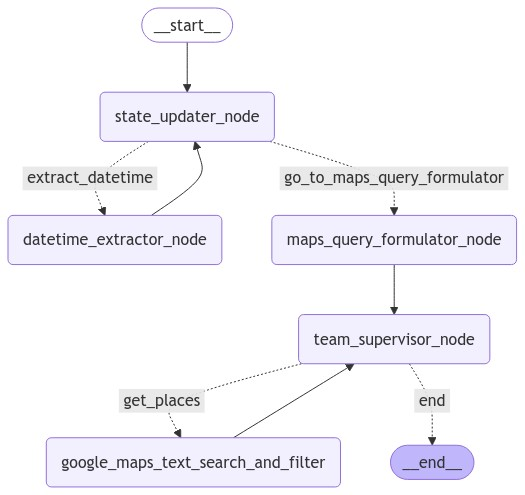

In [135]:
from IPython.display import Image, display

try:
    display(Image(food_finder_agent.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [166]:
DEFAULT_AGENT_STATE: AgentState = {
    "when_to_eat_specified": False,
    "datetime_extracted": False,
    "preferred_price_level": "PRICE_LEVEL_UNSPECIFIED",
    "desired_star_rating": 0.0,
    "user_coordinates": None,
    "preferred_direction": "any",
    "desired_max_distance_meters": 16093.0,  # 10 miles
    "user_preferences": UserPreferences(),
    "valid_places": {},
    "invalid_places": {},
    "found_place": False
}

def create_initial_state(user_input: str, user_coordinates: Tuple[float, float] | None = None) -> AgentState:
    return AgentState({
        **DEFAULT_AGENT_STATE,
        "messages": [HumanMessage(content=user_input)],
        "user_coordinates": user_coordinates
    })

In [161]:
# Test 1 from the test suite
#user_input = "I am hungry and want to find somewhere to get some dinner. I want to eat at 7 for about an hour. I am going by myself. I am feeling like having Asian Cuisine. I dont want to drive more than 3 miles."
user_input = "Im looking for a place to have dinner around 7 PM, preferably somewhere within 10 miles of downtown. I'd love a spot with a cozy atmosphere and a good selection of vegetarian dishes, but I'm open to other options if they have unique or standout menu items. Bonus points if they have outdoor seating and a view!"
# Our anchor coordinate (in Austin)
user_coordinates = (30.320156, -97.720618)

initial_state = create_initial_state(user_input, user_coordinates)

In [112]:
import logging
logging.basicConfig(filename='debug.log', level=logging.DEBUG)

In [168]:
tool_called = False
for chunk in food_finder_agent.stream(initial_state):
    for key, value in chunk.items():
        print(f"Output from node '{key}':")
        print("---")
        if key == 'google_maps_text_search_and_filter':
            print(value['messages'][0].content)
            tool_called = True
        elif key == 'team_supervisor_node':
            if tool_called:
                print(value['messages'][0].content)
            else:
                print(value['messages'])
        else:
            print(value)

Output from node 'state_updater_node':
---
{'when_to_eat_specified': False, 'preferred_price_level': 'PRICE_LEVEL_UNSPECIFIED', 'desired_star_rating': 0, 'preferred_direction': 'any', 'desired_max_distance_meters': 16093.0, 'user_preferences': UserPreferences(desired_cuisines=PreferenceWeight(value=['Vegetarian'], weight=0.5), party_size=PreferenceWeight(value=1, weight=1.0), desired_time_and_stay_duration=(datetime.datetime(2024, 9, 25, 15, 2, 7, 846105), 60), desired_minimum_num_ratings=PreferenceWeight(value=0, weight=0.3), dietary_requests=PreferenceWeight(value=['Vegetarian'], weight=0.8), wants_family_friendly=PreferenceWeight(value=False, weight=0.6), wants_childrens_menu=PreferenceWeight(value=False, weight=0.5), wants_free_parking=PreferenceWeight(value=True, weight=0.8), wants_outdoor_seating=PreferenceWeight(value=True, weight=0.5), wants_live_music=PreferenceWeight(value=False, weight=0.3), wants_dessert=PreferenceWeight(value=False, weight=0.3), wants_beer=PreferenceWeight

In [224]:
DEFAULT_AGENT_STATE: AgentState = {
    "preferred_price_level": "PRICE_LEVEL_UNSPECIFIED",
    "desired_star_rating": 0.0,
    "user_coordinates": None,
    "preferred_direction": "any",
    "desired_max_distance_meters": 16093.0,  # 10 miles
    "user_preferences": UserPreferences(),
    "valid_places": {},
    "invalid_places": {},
    "found_place": False
}

In [225]:
from app.schemas import Coordinates

In [231]:
state = AgentState({
    **DEFAULT_AGENT_STATE,
    "messages": [HumanMessage(content='I am hungry and want to find somewhere to get some dinner. I want to eat at 7 for about an hour. I am going by myself. I am feeling like having Asian Cuisine. I dont want to drive more than 3 miles.')],
    "user_coordinates": (44.3546873, -115.9973871)
})

In [232]:
from app.schemas import Coordinates
from uuid import uuid4
sample_from_fastapi = {'input':state, 'config': {'configurable': {'thread_id': '67bc4645-44f7-41f9-9db1-71d7839f317f', 'model': 'gpt-4o-mini'}, 'run_id':uuid4()}}

In [ ]:
response = food_finder_agent.invoke(**sample_from_fastapi)

In [ ]:
tool_called = False
for chunk in food_finder_agent.stream(sample_from_fastapi):
    for key, value in chunk.items():
        print(f"Output from node '{key}':")
        print("---")
        if key == 'google_maps_text_search_and_filter':
            print(value['messages'][0].content)
            tool_called = True
        elif key == 'team_supervisor_node':
            if tool_called:
                print(value['messages'][0].content)
            else:
                print(value['messages'])
        else:
            print(value)

In [199]:
response.get('messages')[-1].content

"Here are the places I found for you:\n\n1. Bento Teppanyaki Asian Cuisine - Chinese Restaurant. Located at 1201 Barbara Jordan Blvd #1230, Austin, TX 78723, USA. Phone number is (512) 296-2288. Rating is 4.7 with 118 ratings.\n2. Shu Shu's Asian Cuisine - Chinese Restaurant. Located at 8303 Burnet Rd #1, Austin, TX 78757, USA. Phone number is (512) 291-3002. Rating is 4.3 with 792 ratings.\n3. 1618 Asian Fusion - Restaurant. Located at 1618 E Riverside Dr, Austin, TX 78741, USA. Phone number is (512) 462-9999. Rating is 4.7 with 3100 ratings.\n4. The Pho Asian Fusion - Restaurant. Located at 609 Clayton Ln #100, Austin, TX 78752, USA. Phone number is (512) 551-3379. Rating is 3.9 with 283 ratings.\n5. Chi'Lantro - Restaurant. Located at 1201 Barbara Jordan Blvd Suite 1460, Austin, TX 78723, USA. Phone number is (512) 900-7648. Rating is 4.4 with 474 ratings.\n"

## Following the docs on passing  runtime values to tools (in our case, the state)

In our case, we want to inject the state, because it contains important information on the user's food preferences (set by earlier agents), and the google maps tool(s) must index this state, to filter the results properly. Also, as the user communicates with the later agent (supervisor), he/she may request certain things require access to information on searched places or that faciliate updating information on places.

We can use `InjectedState` annotation to mark agurments to the tool as required graph state, hence, these args wont be generated by the model. Also, using `ToolNode` will allow us to create a graph node consisting of tools, which takes care of injecting state into tools.

### First, here is a simple example of some tools calls annotated in such a way

In [102]:
from typing import List, Dict, Any
from typing_extensions import Annotated, TypedDict
from langchain_core.messages import BaseMessage, AIMessage
from langchain_core.tools import tool
from langgraph.prebuilt import InjectedState, ToolNode

class AgentState(BaseModel):
    messages: List[BaseMessage]
    foo: str
    foo2: str
    places: List[str]

def get_maps_text_search_parameters(state: Dict[str, Any]) -> str:
    return state["foo"] + state["foo2"]
@tool
def state_tool(x: int, state: Annotated[dict, InjectedState]) -> str:
    '''Do something with state.'''
    state["places"].append(get_maps_text_search_parameters(state))
    if len(state["messages"]) > 2:
        return state["foo"] + str(x)
    else:
        return "not enough messages"

@tool
def foo_tool(x: int, foo: Annotated[str, InjectedState("foo")], foo2: Annotated[str, InjectedState("foo2")], places: Annotated[List[str], InjectedState("places")]) -> str:
    '''Do something else with state.'''
    return foo + str(x + 1) + places[0]

node = ToolNode([state_tool, foo_tool])

tool_call1 = {"name": "state_tool", "args": {"x": 1}, "id": "1", "type": "tool_call"}
tool_call2 = {"name": "foo_tool", "args": {"x": 1}, "id": "2", "type": "tool_call"}
state = {
    "messages": [AIMessage("", tool_calls=[tool_call1, tool_call2])],
    "foo": "bar",
    "foo2": "bar2",
    "places": []
}
node.invoke(state)
# [
#     ToolMessage(content='not enough messages', name='state_tool', tool_call_id='1'),
#     ToolMessage(content='bar2', name='foo_tool', tool_call_id='2')
# ]

{'messages': [ToolMessage(content='not enough messages', name='state_tool', tool_call_id='1'),
  ToolMessage(content='bar2barbar2', name='foo_tool', tool_call_id='2')]}

### Now, the tutorial example

Tutorial followed: https://langchain-ai.github.io/langgraph/how-tos/pass-run-time-values-to-tools/#setup

In [51]:
model = ChatOpenAI()

In [146]:
from typing import List, Tuple
from typing_extensions import Annotated
from langchain_core.documents import Document
from langchain_core.tools import tool
from langgraph.prebuilt import InjectedState
from langchain_core.messages import ToolMessage
from pydantic import BaseModel


@tool(parse_docstring=True, response_format="content_and_artifact")
def get_context(question: List[str]) -> Tuple[str, List[Document]]:
    """Get context on the question.

    Args:
        question: The user question
    """
    # return constant dummy output
    docs = [
        Document(
            "FooBar company just raised 1 Billion dollars!",
            metadata={"source": "twitter"},
        ),
        Document(
            "FooBar company is now only hiring AI's", metadata={"source": "twitter"}
        ),
        Document(
            "FooBar company was founded in 2019", metadata={"source": "wikipedia"}
        ),
        Document(
            "FooBar company makes friendly robots", metadata={"source": "wikipedia"}
        ),
    ]
    #return "~~~~GOT IT DUDE!~~~~", ("\n\n".join(doc.page_content for doc in docs), docs)
    return "\n\n".join(doc.page_content for doc in docs), docs


@tool(parse_docstring=True, response_format="content_and_artifact")
def cite_context_sources(
    claim: str, state: Annotated[AgentState, InjectedState]
) -> Tuple[str, List[Document]]:
    """Cite which source a claim was based on.

    Args:
        claim: The claim that was made.
    """
    docs = []
    # We get the potentially cited docs from past ToolMessages in our state.
    for msg in state["messages"]:
        if isinstance(msg, ToolMessage) and msg.name == "get_context":
            docs.extend(msg.artifact)

    class Cite(BaseModel):
        """Return the index(es) of the documents that justify the claim"""

        indexes: List[int]

    structured_model = model.with_structured_output(Cite) # TODO: this is good to know for state updater agent
    system = f"Which of the following documents best justifies the claim:\n\n{claim}"
    context = "\n\n".join(
        f"Document {i}:\n" + doc.page_content for i, doc in enumerate(docs)
    )
    citation = structured_model.invoke([("system", system), ("human", context)])
    cited_docs = [docs[i] for i in citation.indexes]
    sources = ", ".join(doc.metadata["source"] for doc in cited_docs)

    #return "~~~~GOT IT DUDE!~~~~", (sources, cited_docs)
    return sources, cited_docs

In [140]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage


# class AgentState(BaseModel):
#     messages: Annotated[Sequence[BaseMessage], operator.add]
    #content: str

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [141]:
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import ToolNode

model = ChatOpenAI(model="gpt-4o", temperature=0)


# Define the function that determines whether to continue or not
def should_continue(state, config):
    messages = state.messages
    #messages = state['messages']
    last_message = messages[-1]
    #print("DEBUG: last_message is", last_message)
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


tools = [get_context, cite_context_sources]
#tools = [get_context]


# Define the function that calls the model
# def call_model(state: AgentState, config):
#     messages = state.messages
#     model_with_tools = model.bind_tools(tools)
#     response = model_with_tools.invoke(messages)

#     last_message = state.messages[-1]
#     if type(last_message) == ToolMessage:
#         print("DEBUG: last_message is:")
#         print("DEBUG: last_message.content is", last_message.content)
#         print("DEBUG: last_message.tool_call_id is", last_message.tool_call_id)
#         print("DEBUG: last_message.artifact[0] is", last_message.artifact[0])
#         print("DEBUG: last_message.artifact[1] is", last_message.artifact[1])
#         print("DEBUG: last_message.name is", last_message.name) 
#         return {
#             "messages": [response],
#             "content": last_message.content
#         }
#     # We return a list, because this will get added to the existing list
#     return {"messages": [response], "content": state.content}

def call_model(state, config):
    messages = state.messages
    #messages = state['messages']
    model_with_tools = model.bind_tools(tools)
    response = model_with_tools.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# ToolNode will automatically take care of injecting state into tools
tool_node = ToolNode(tools)

In [148]:
from langgraph.graph import END, START, StateGraph

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

In [149]:
messages = [HumanMessage(content="what's the latest news about FooBar")]

In [150]:
for chunk in app.stream(
    {"messages": messages, "content": ""}
):
    for key, value in chunk.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
        messages.extend(value["messages"])

Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_E781TqCV3GMUFtXg8oGpK9CF', 'function': {'arguments': '{"question":["latest news about FooBar"]}', 'name': 'get_context'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 87, 'total_tokens': 106, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_52a7f40b0b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-11990e3a-a0e9-4978-aa11-8d3e62c8e174-0', tool_calls=[{'name': 'get_context', 'args': {'question': ['latest news about FooBar']}, 'id': 'call_E781TqCV3GMUFtXg8oGpK9CF', 'type': 'tool_call'}], usage_metadata={'input_tokens': 87, 'output_tokens': 19, 'total_tokens': 106})]}
Output from node 'action':
---
{'messages': [ToolMessage(content="FooBar company just raised 1 Billion dollars!\n\nFooBar company is now only hiring AI's\n\nFooBar 

In [139]:
messages.append(HumanMessage("where did you get this information?"))
for chunk in app.stream(
    {"messages": messages, "content": ""}
):
    for key, value in chunk.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
        messages.extend(value["messages"])

Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Jvkgd6QZqE1GjwrlW4LXdPOU', 'function': {'arguments': '{"claim":"FooBar company just raised 1 Billion dollars!"}', 'name': 'cite_context_sources'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 182, 'total_tokens': 207, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_e375328146', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3bbda366-8955-4700-b51d-e83d6727f6c8-0', tool_calls=[{'name': 'cite_context_sources', 'args': {'claim': 'FooBar company just raised 1 Billion dollars!'}, 'id': 'call_Jvkgd6QZqE1GjwrlW4LXdPOU', 'type': 'tool_call'}], usage_metadata={'input_tokens': 182, 'output_tokens': 25, 'total_tokens': 207})]}
Output from node 'action':
---
{'messages': [ToolMessage(content='twitter', name='cite_context_sources', tool_ca